In [1]:
import os
from os.path import abspath, join, basename
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datatable as dt
from scipy.stats import ranksums

In [2]:
# Set working directory
os.chdir(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
print(f"Current working directory = {os.getcwd()}")

Current working directory = C:\Users\darkg\PycharmProjects\ny_metastasis


In [3]:
# Import local libraries
from src.plot_centroids import plot_centroids
from src.read_marker import read_marker
from src.plot_marker_intensity import plot_marker_intensity
from src.measure_marker_positive_mean_distance import measure_marker_positive_mean_distance
from src.read_markers_labeled import read_markers_labeled
from src.plot_distributions import plot_distributions, plot_distribution_boxen
from src.get_marker_intensities import get_marker_intensities
from src.get_marker_positive_cells import get_marker_positive_cells
from src.plot_sample_distributions import plot_sample_distributions
from src.plot_cell_contours_plotly import plot_cell_contours_plotly
from src.count_marker_positive_neighborhood import count_marker_positive_neighborhood

## Set paths

In [4]:
# Pathways to metadata and data
folder_path = abspath("./data/mcmicro_quants")
metadata_path = abspath("./data/metadata.csv")
image_raw_path = abspath("./data/cell.tif")
image_mask_path = abspath("./data/cell_mask.tif")
image_quants_path = abspath("./data/mcmicro_quants/mesmer-N-2016-2156-1_hBN220215_16738-35540_cell.csv")

## Set plot style

In [5]:
# Set palette
sns.set_style("darkgrid")
palette = {"MBM":"#A80D11",
           "ECM":"#008DB8"}

## Load metadata

In [6]:
# Read in metadata, set file name as index
metadata = pd.read_csv(metadata_path, index_col="file")
metadata.head()

,sample,source,n,tissue
file,,,,
mesmer-N-2017-1885-1_hBN220215_18999-57405_cell.csv,N-2017-1885-1_hBN220215,brain,18147,MBM
mesmer-N-2016-671-1_hBN220215_12114-54527_cell.csv,N-2016-671-1_hBN220215,brain,16726,MBM
mesmer-N-2011-15-1_Restain_hBN220216_5580-43693_cell.csv,N-2011-15-1_Restain_hBN220216,brain,16689,MBM
mesmer-N-2017-666-1_hBN220215_14872-44785_cell.csv,N-2017-666-1_hBN220215,brain,45474,MBM
mesmer-N-2018-693_Restain_hBN220216_12057-35223_cell.csv,N-2018-693_Restain_hBN220216,brain,13070,MBM


In [7]:
# Get total number of identified cells
metadata["n"].sum()

8941675

In [8]:
#Get number of cells per tissue
for g, d in metadata.groupby("tissue"):
    print(f"#  Cells in {g} = {d['n'].sum()}")
    print(f"Fraction in {g} = {d['n'].sum()/metadata['n'].sum():.4f}")

#  Cells in ECM = 5352494
Fraction in ECM = 0.5986
#  Cells in MBM = 3589181
Fraction in MBM = 0.4014


## Get a cutoff for CD138 positive cells

In [9]:
%%time
# Iterate over all images and get only the values for CD138
# Read all marker intensities
marker = "CD138"
all_data = read_marker(folder_path, marker)
all_data.head()

CPU times: total: 55.9 s
Wall time: 12.1 s


,CD138
0,0.169846
1,0.011727
2,0.044308
3,0.010719
4,0.113773


In [10]:
# Get cutoff value based on all images
cutoff = np.percentile(all_data["CD138"], q=99)
print(cutoff)

1.6312074160575833


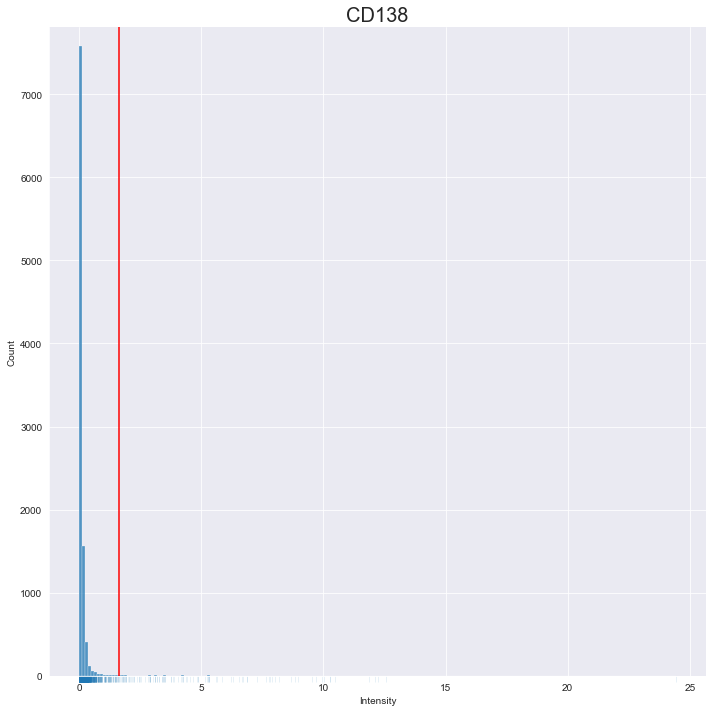

In [11]:
# show cutoff value
plot_marker_intensity(all_data, marker, cutoff,
                      out=[abspath("./out/mets-density_CD138-raw-gated.pdf"),
                           abspath("./out/mets-density_CD138-raw-gated.png")])

## Check if threshold makes sense

In [12]:
# Visualize threshold
plot_centroids(image_quants_path, marker, cutoff,
               out=abspath(f"./out/{basename(image_raw_path)}_CD138.html"))

## Calculate the average euclidean distance for CD138 positive cells per image

In [11]:
%%time
metadata["distances"] = measure_marker_positive_mean_distance(folder_path, marker, cutoff)
metadata.head()

CPU times: total: 1min 50s
Wall time: 22.2 s


,sample,source,n,tissue,distances
file,,,,,
mesmer-N-2017-1885-1_hBN220215_18999-57405_cell.csv,N-2017-1885-1_hBN220215,brain,18147,MBM,442.133949
mesmer-N-2016-671-1_hBN220215_12114-54527_cell.csv,N-2016-671-1_hBN220215,brain,16726,MBM,NaN
mesmer-N-2011-15-1_Restain_hBN220216_5580-43693_cell.csv,N-2011-15-1_Restain_hBN220216,brain,16689,MBM,NaN
mesmer-N-2017-666-1_hBN220215_14872-44785_cell.csv,N-2017-666-1_hBN220215,brain,45474,MBM,1117.980260
mesmer-N-2018-693_Restain_hBN220216_12057-35223_cell.csv,N-2018-693_Restain_hBN220216,brain,13070,MBM,NaN


In [12]:
# Images without CD138 positive cells
metadata["distances"].isna().sum()

155

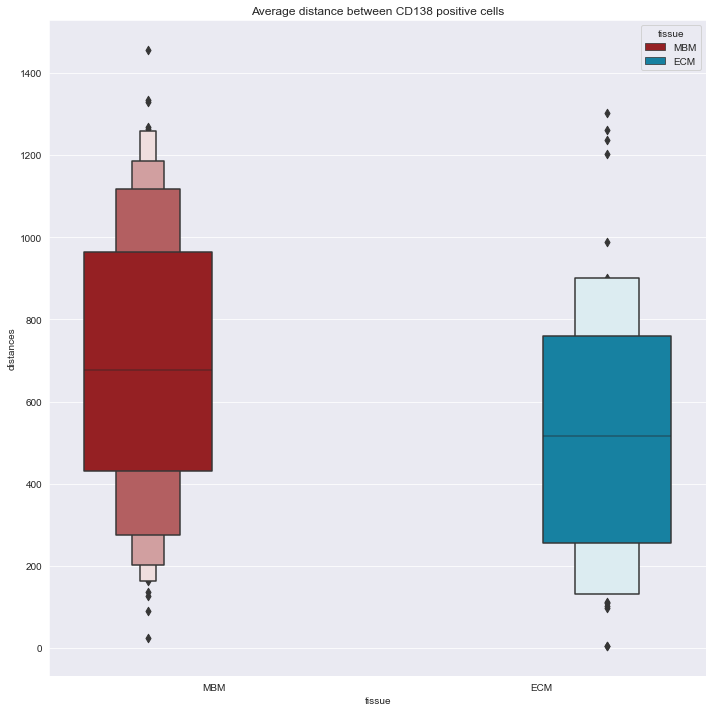

In [16]:
# CD138 average distance
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.boxenplot(data=metadata, x="tissue", y="distances", hue="tissue", palette=palette, ax=ax)
ax.set_title("Average distance between CD138 positive cells", fontsize=20)
plt.tight_layout()
plt.savefig(abspath("../out/mets-boxen-cd138distance.png"), dpi=300)

In [17]:
# Average distance of CD138 positive cells on Brain samples
metadata[metadata["tissue"]=="MBM"]["distances"].mean()

692.5129320057944

In [18]:
# Average distance of CD138 positive cells on Liver samples
metadata[metadata["tissue"]=="ECM"]["distances"].mean()

533.1012915793951

## Let's check the ratio of CD138 positive cells per image

In [13]:
%%time
metadata["CD138_positive_cells"] = get_marker_positive_cells(folder_path, marker, cutoff)
metadata.head()

CPU times: total: 58.4 s
Wall time: 10.3 s


,sample,source,n,tissue,distances,CD138_positive_cells
file,,,,,,
mesmer-N-2017-1885-1_hBN220215_18999-57405_cell.csv,N-2017-1885-1_hBN220215,brain,18147,MBM,442.133949,25
mesmer-N-2016-671-1_hBN220215_12114-54527_cell.csv,N-2016-671-1_hBN220215,brain,16726,MBM,NaN,0
mesmer-N-2011-15-1_Restain_hBN220216_5580-43693_cell.csv,N-2011-15-1_Restain_hBN220216,brain,16689,MBM,NaN,1
mesmer-N-2017-666-1_hBN220215_14872-44785_cell.csv,N-2017-666-1_hBN220215,brain,45474,MBM,1117.980260,1099
mesmer-N-2018-693_Restain_hBN220216_12057-35223_cell.csv,N-2018-693_Restain_hBN220216,brain,13070,MBM,NaN,1


In [14]:
%%time
metadata["CD138_positive_cells_proportion"] = metadata["CD138_positive_cells"]/metadata["n"]
metadata.head()

CPU times: total: 0 ns
Wall time: 2.99 ms


,sample,source,n,tissue,distances,CD138_positive_cells,CD138_positive_cells_proportion
file,,,,,,,
mesmer-N-2017-1885-1_hBN220215_18999-57405_cell.csv,N-2017-1885-1_hBN220215,brain,18147,MBM,442.133949,25,0.001378
mesmer-N-2016-671-1_hBN220215_12114-54527_cell.csv,N-2016-671-1_hBN220215,brain,16726,MBM,NaN,0,0.000000
mesmer-N-2011-15-1_Restain_hBN220216_5580-43693_cell.csv,N-2011-15-1_Restain_hBN220216,brain,16689,MBM,NaN,1,0.000060
mesmer-N-2017-666-1_hBN220215_14872-44785_cell.csv,N-2017-666-1_hBN220215,brain,45474,MBM,1117.980260,1099,0.024168
mesmer-N-2018-693_Restain_hBN220216_12057-35223_cell.csv,N-2018-693_Restain_hBN220216,brain,13070,MBM,NaN,1,0.000077


CPU times: total: 3.25 s
Wall time: 1.53 s


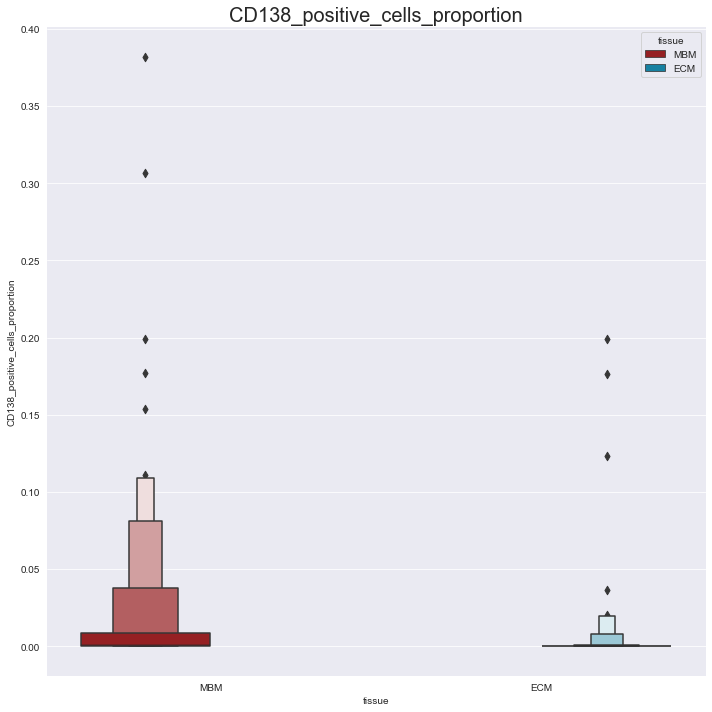

In [15]:
%%time
plot_distribution_boxen(metadata, marker="CD138_positive_cells_proportion", hue="tissue", palette=palette,
                        out=[abspath("./out/mets-boxen-CD138pos_cell_proportion.pdf"),
                             abspath("./out/mets-boxen-CD138pos_cell_proportion.png")])

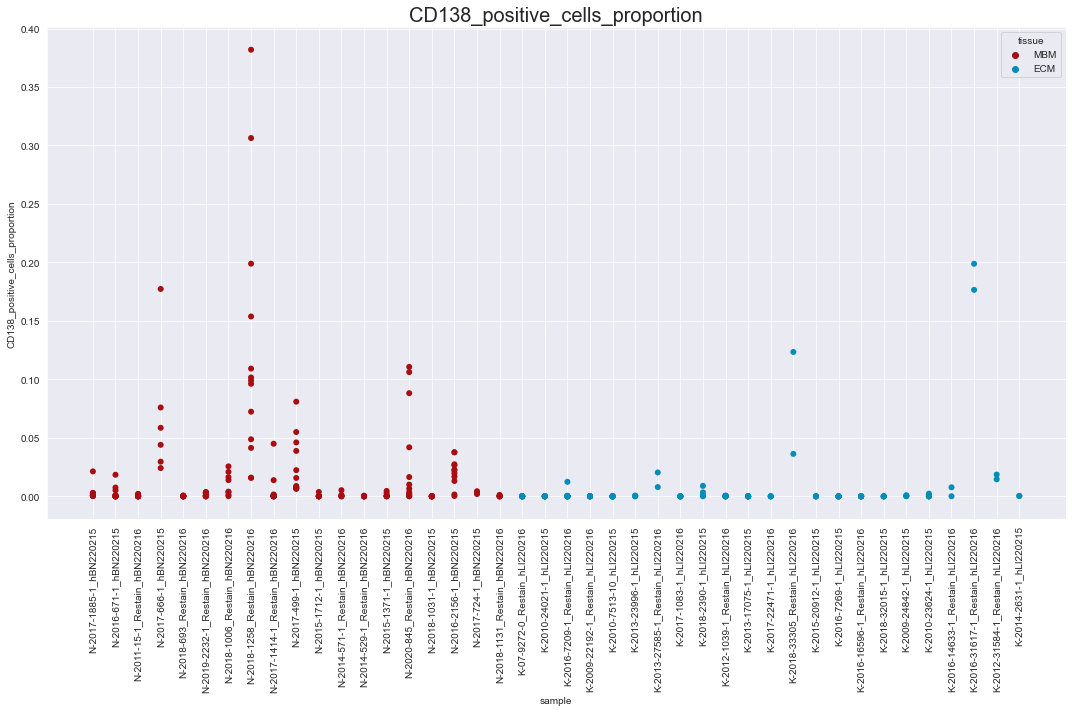

In [33]:
plot_sample_distributions(metadata, x="sample", marker="CD138_positive_cells_proportion", hue="tissue", palette=palette,
                          out=[abspath("./out/mets-boxen-CD138pos_cell_proportion_by_sample.pdf"),
                               abspath("./out/mets-boxen-CD138pos_cell_proportion_by_sample.png")])

In [16]:
for g,d in metadata.groupby("tissue"):
    print(f"Average proportion of {marker}+ cells per image in {g} = {d['CD138_positive_cells_proportion'].mean():.4f}")

Average proportion of CD138+ cells per image in ECM = 0.0045
Average proportion of CD138+ cells per image in MBM = 0.0168


## CD138 Immediate neighborhood 30, 40 and 50 micrometers

In [17]:
%%time
# Add distances to metadata
metadata["CD138_positive_cells_in_neighborhood_30um"] = count_marker_positive_neighborhood(folder_path, marker, cutoff, distance=30)
metadata["CD138_positive_cells_in_neighborhood_40um"] = count_marker_positive_neighborhood(folder_path, marker, cutoff, distance=40)
metadata["CD138_positive_cells_in_neighborhood_50um"] = count_marker_positive_neighborhood(folder_path, marker, cutoff, distance=50)

CPU times: total: 5min 42s
Wall time: 1min 6s


In [18]:
print("Results for 30um")
for g, d in metadata.groupby("tissue"):
    print(f"Average # of cells in the immediate neighborhood of {marker}+ cells per image in {g} = {d['CD138_positive_cells_in_neighborhood_30um'].mean():.4f}")

Results for 30um
Average # of cells in the immediate neighborhood of CD138+ cells per image in ECM = 0.8568
Average # of cells in the immediate neighborhood of CD138+ cells per image in MBM = 1.2407


In [19]:
print("Results for 40um")
for g, d in metadata.groupby("tissue"):
    print(f"Average # of cells in the immediate neighborhood of {marker}+ cells per image in {g} = {d['CD138_positive_cells_in_neighborhood_40um'].mean():.4f}")

Results for 40um
Average # of cells in the immediate neighborhood of CD138+ cells per image in ECM = 1.2084
Average # of cells in the immediate neighborhood of CD138+ cells per image in MBM = 1.8326


In [20]:
print("Results for 50um")
for g, d in metadata.groupby("tissue"):
    print(f"Average # of cells in the immediate neighborhood of {marker}+ cells per image in {g} = {d['CD138_positive_cells_in_neighborhood_50um'].mean():.4f}")

Results for 50um
Average # of cells in the immediate neighborhood of CD138+ cells per image in ECM = 1.5868
Average # of cells in the immediate neighborhood of CD138+ cells per image in MBM = 2.4833


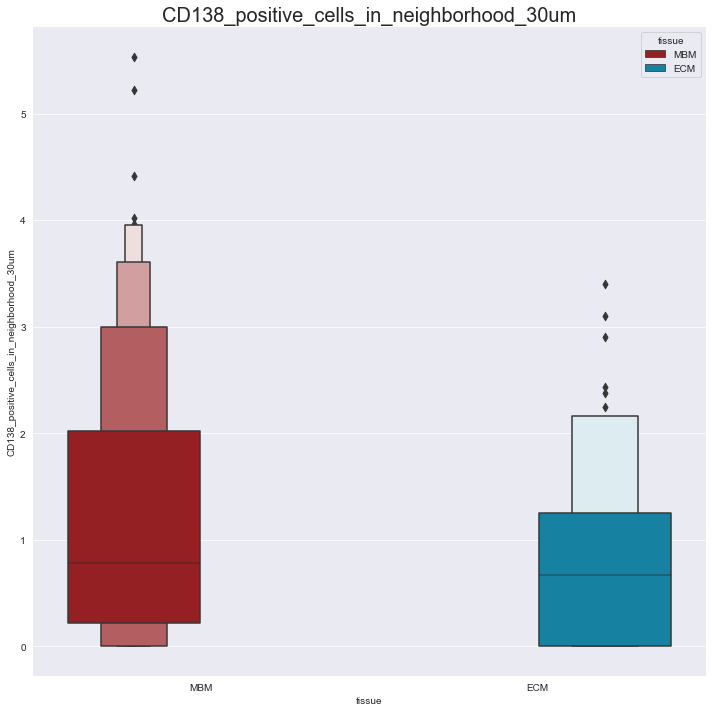

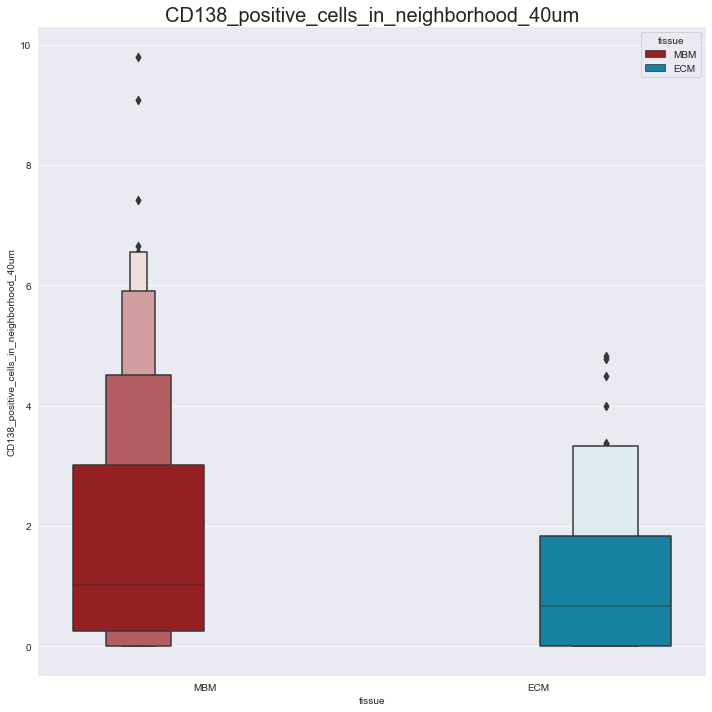

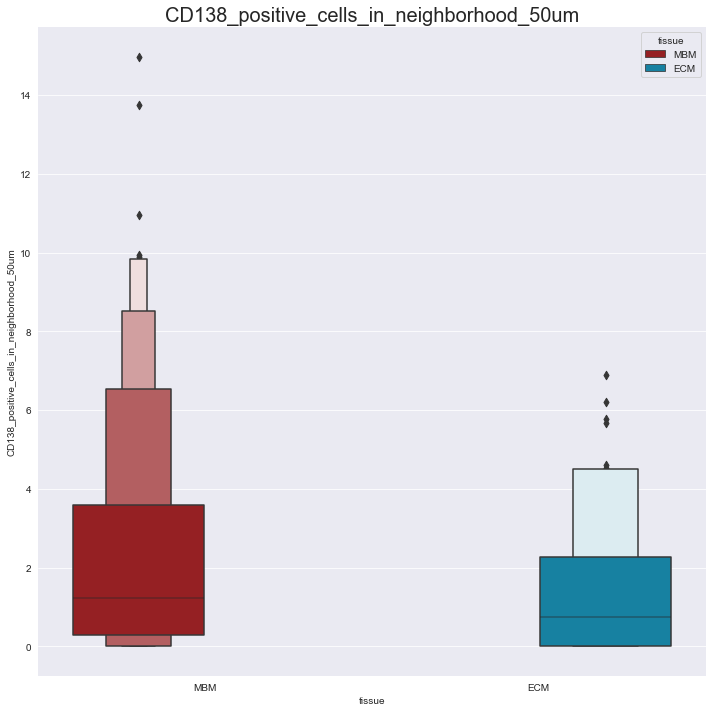

In [30]:
# CD138 average neighborhood
plot_distribution_boxen(metadata, marker="CD138_positive_cells_in_neighborhood_30um", hue="tissue", palette=palette,
                        out=[abspath("./out/mets-boxen-CD138_positive_cells_in_neighborhood_30um.pdf"),
                             abspath("./out/mets-boxen-CD138_positive_cells_in_neighborhood_30um.png")])

plot_distribution_boxen(metadata, marker="CD138_positive_cells_in_neighborhood_40um", hue="tissue", palette=palette,
                        out=[abspath("./out/mets-boxen-CD138_positive_cells_in_neighborhood_40um.pdf"),
                             abspath("./out/mets-boxen-CD138_positive_cells_in_neighborhood_40um.png")])

plot_distribution_boxen(metadata, marker="CD138_positive_cells_in_neighborhood_50um", hue="tissue", palette=palette,
                        out=[abspath("./out/mets-boxen-CD138_positive_cells_in_neighborhood_50um.pdf"),
                             abspath("./out/mets-boxen-CD138_positive_cells_in_neighborhood_50um.png")])

## CD138 neighborhood stats

In [35]:
# Wilcoxon ranksum test for CD138+ cells in neighborhood between MBM and ECM tissues
res_hood_30 = ranksums(metadata[metadata["tissue"]=="MBM"]["CD138_positive_cells_in_neighborhood_30um"], metadata[metadata["tissue"]=="ECM"]["CD138_positive_cells_in_neighborhood_30um"])
res_hood_30

RanksumsResult(statistic=-5.571946852449774, pvalue=2.5190827733919636e-08)

In [36]:
res_hood_40 = ranksums(metadata[metadata["tissue"]=="MBM"]["CD138_positive_cells_in_neighborhood_40um"], metadata[metadata["tissue"]=="ECM"]["CD138_positive_cells_in_neighborhood_40um"])
res_hood_40

RanksumsResult(statistic=-5.727769582496772, pvalue=1.0175965101504792e-08)

In [37]:
res_hood_50 = ranksums(metadata[metadata["tissue"]=="MBM"]["CD138_positive_cells_in_neighborhood_50um"], metadata[metadata["tissue"]=="ECM"]["CD138_positive_cells_in_neighborhood_50um"])
res_hood_50

RanksumsResult(statistic=-5.759162440198549, pvalue=8.453232440735367e-09)

## Check CD138 total expression per sample

In [21]:
%%time
all_images = read_markers_labeled(folder_path, marker, metadata[["tissue", "sample"]])
all_images = all_images.sort_values(by="tissue", ascending=False)
all_images.head()

CPU times: total: 1min
Wall time: 20.1 s


,CD138,tissue,sample
8941674,0.550128,MBM,N-2020-845_Restain_hBN220216
6548882,1.599308,MBM,N-2017-1414-1_Restain_hBN220216
6548893,0.877067,MBM,N-2017-1414-1_Restain_hBN220216
6548892,0.509738,MBM,N-2017-1414-1_Restain_hBN220216
6548891,1.181646,MBM,N-2017-1414-1_Restain_hBN220216


In [22]:
# Log scale the data
scaled = np.log(all_images[marker])
scaled = pd.DataFrame(scaled, columns=[marker])
scaled = scaled[~np.isinf(scaled[marker])]
scaled["tissue"] = all_images["tissue"]
scaled["sample"] = all_images["sample"]
scaled = scaled.sort_values(by="tissue", ascending=False)
scaled.head()

C:\Users\darkg\PycharmProjects\sandbox\venv\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,CD138,tissue,sample
8941674,-0.597604,MBM,N-2020-845_Restain_hBN220216
8940962,0.408079,MBM,N-2020-845_Restain_hBN220216
8940920,-0.543420,MBM,N-2020-845_Restain_hBN220216
8940919,-1.872661,MBM,N-2020-845_Restain_hBN220216
8940918,-2.061687,MBM,N-2020-845_Restain_hBN220216


CPU times: total: 1min 18s
Wall time: 1min 20s


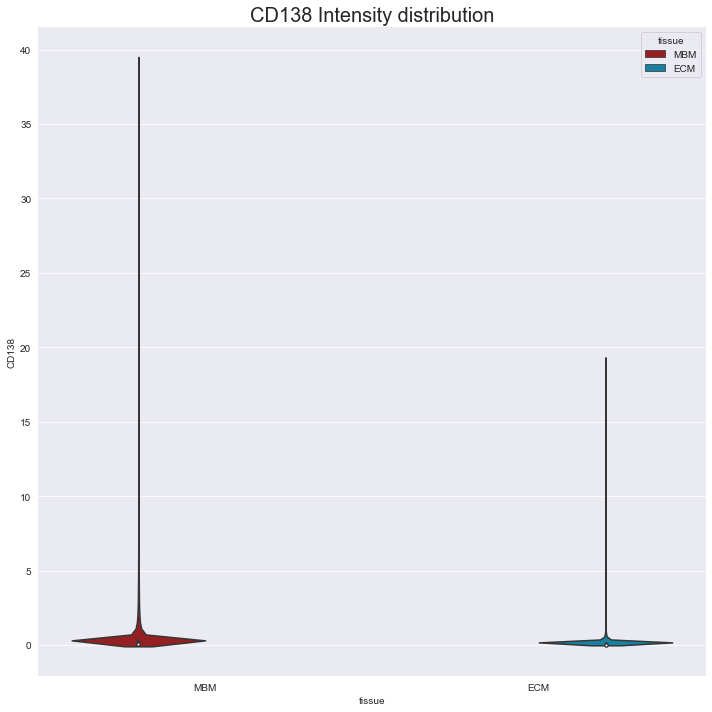

In [23]:
%%time
# Plot intensity distribution by tissue
plot_distributions(all_images, marker, hue="tissue", palette=palette,
                   out=[abspath("./out/mets-violin_CD138-color_MBM_ECM-raw.pdf"),
                        abspath("./out/mets-violin_CD138-color_MBM_ECM-raw.png")])

CPU times: total: 1min 6s
Wall time: 1min 6s


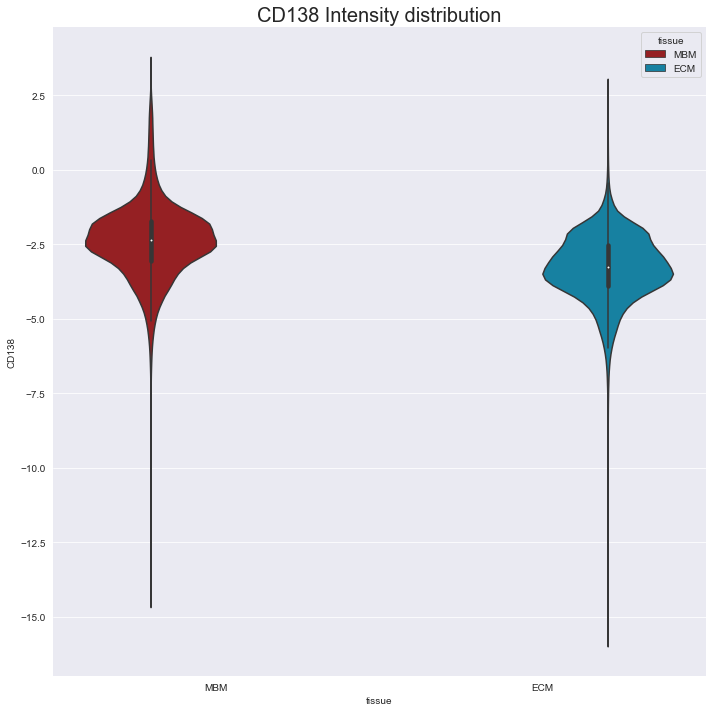

In [24]:
%%time
plot_distributions(scaled, marker, hue="tissue", palette=palette,
                            out=[abspath("./out/mets-violin_CD138-color_MBM_ECM-log.pdf"),
                                 abspath("./out/mets-violin_CD138-color_MBM_ECM-log.png")])

CPU times: total: 1.53 s
Wall time: 1.58 s


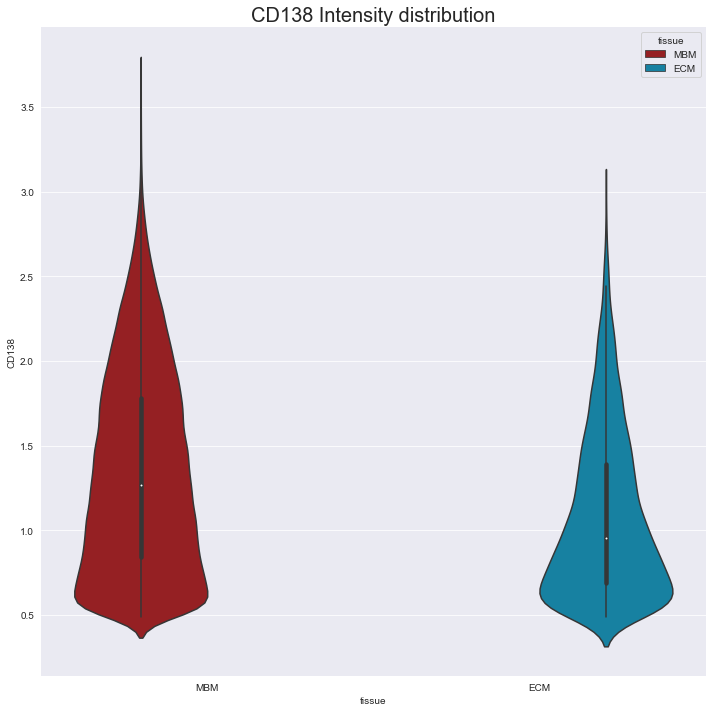

In [25]:
%%time
scaled_pos = scaled[scaled["CD138"]>=np.log(cutoff)]
scaled_pos
plot_distributions(scaled_pos, marker, hue="tissue", palette=palette,
                            out=[abspath("./out/mets-violin_CD138pos-intensity_by_tissue-log.pdf"),
                                 abspath("./out/mets-violin_CD138pos-intensity_by_tissue-log.png")])

CPU times: total: 3.64 s
Wall time: 3.81 s


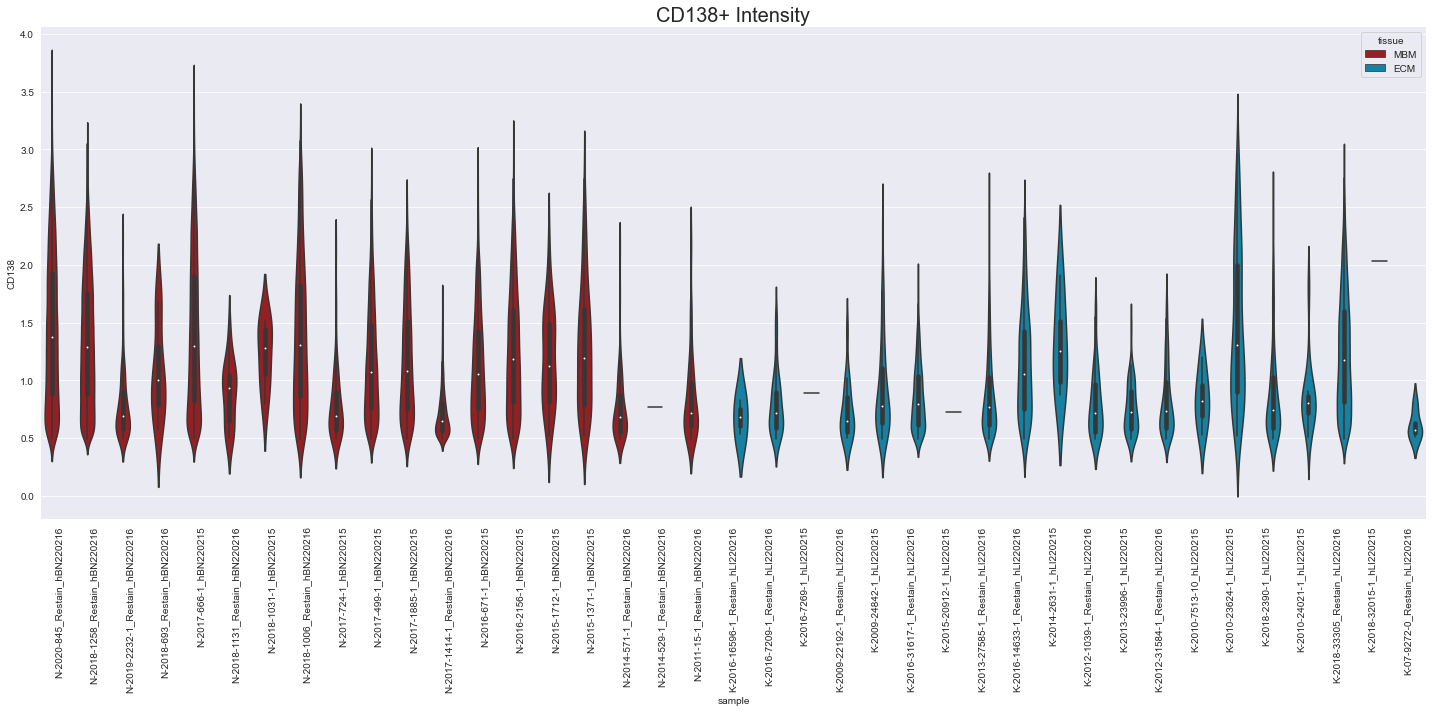

In [26]:
%%time
# Plot violin plot for raw data
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.violinplot(data=scaled_pos, x="sample", y="CD138", hue="tissue", palette=palette, ax=ax)
ax.set_title("CD138+ Intensity", fontsize=20)
ax.tick_params(axis='x', labelrotation=90)
sns.despine(left=True)
plt.tight_layout()
fig.savefig(abspath("./out/mets-violin_CD138pos_intensity-by_sample_log.pdf"), dpi=300)
fig.savefig(abspath("./out/mets-violin_CD138pos_intensity-by_sample_log.png"), dpi=300)

## Get CD138 mean marker intensities

In [27]:
%%time
metadata["CD138_intensity"] = get_marker_intensities(folder_path, marker, cutoff=0)
metadata.head()

CPU times: total: 54.1 s
Wall time: 11.4 s


,sample,source,n,tissue,distances,CD138_positive_cells,CD138_positive_cells_proportion,CD138_positive_cells_in_neighborhood_30um,CD138_positive_cells_in_neighborhood_40um,CD138_positive_cells_in_neighborhood_50um,CD138_intensity
file,,,,,,,,,,,
mesmer-N-2017-1885-1_hBN220215_18999-57405_cell.csv,N-2017-1885-1_hBN220215,brain,18147,MBM,442.133949,25,0.001378,0.360000,0.360000,0.440000,0.033430
mesmer-N-2016-671-1_hBN220215_12114-54527_cell.csv,N-2016-671-1_hBN220215,brain,16726,MBM,NaN,0,0.000000,NaN,NaN,NaN,0.018540
mesmer-N-2011-15-1_Restain_hBN220216_5580-43693_cell.csv,N-2011-15-1_Restain_hBN220216,brain,16689,MBM,NaN,1,0.000060,NaN,NaN,NaN,0.043573
mesmer-N-2017-666-1_hBN220215_14872-44785_cell.csv,N-2017-666-1_hBN220215,brain,45474,MBM,1117.980260,1099,0.024168,1.570519,2.209281,2.866242,0.271221
mesmer-N-2018-693_Restain_hBN220216_12057-35223_cell.csv,N-2018-693_Restain_hBN220216,brain,13070,MBM,NaN,1,0.000077,NaN,NaN,NaN,0.296578


CPU times: total: 3.12 s
Wall time: 794 ms


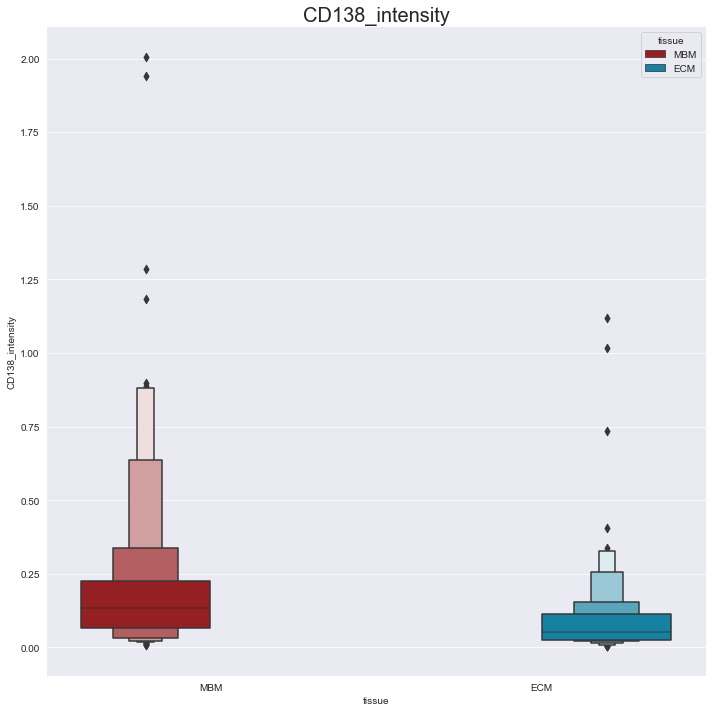

In [28]:
%%time
plot_distribution_boxen(metadata, "CD138_intensity", hue="tissue", palette=palette,
                        out=[abspath("./out/mets-boxen-CD138_mean_intensity_by_tissue.pdf"),
                             abspath("./out/mets-boxen-CD138_mean_intensity_by_tissue.png")])

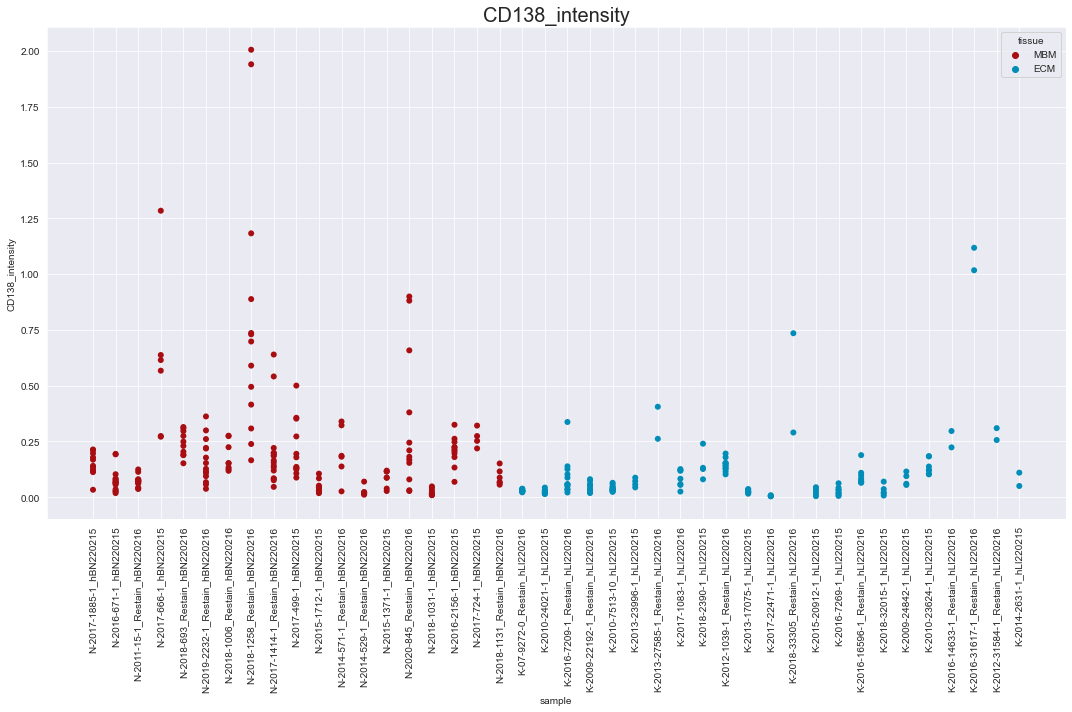

In [29]:
plot_sample_distributions(metadata, x="sample", marker="CD138_intensity", hue="tissue", palette=palette,
                          out=[abspath("./out/mets-scatter-CD138_mean_intensity_by_sample.pdf"),
                               abspath("./out/mets-scatter-CD138_mean_intensity_by_sample.png")])

## Get CD138+ mean marker intensities

In [30]:
%%time
metadata["CD138pos_intensity"] = get_marker_intensities(folder_path, marker, cutoff=cutoff)
metadata.head()

CPU times: total: 57.2 s
Wall time: 10.8 s


,sample,source,n,tissue,distances,CD138_positive_cells,CD138_positive_cells_proportion,CD138_positive_cells_in_neighborhood_30um,CD138_positive_cells_in_neighborhood_40um,CD138_positive_cells_in_neighborhood_50um,CD138_intensity,CD138pos_intensity
file,,,,,,,,,,,,
mesmer-N-2017-1885-1_hBN220215_18999-57405_cell.csv,N-2017-1885-1_hBN220215,brain,18147,MBM,442.133949,25,0.001378,0.360000,0.360000,0.440000,0.033430,2.492253
mesmer-N-2016-671-1_hBN220215_12114-54527_cell.csv,N-2016-671-1_hBN220215,brain,16726,MBM,NaN,0,0.000000,NaN,NaN,NaN,0.018540,NaN
mesmer-N-2011-15-1_Restain_hBN220216_5580-43693_cell.csv,N-2011-15-1_Restain_hBN220216,brain,16689,MBM,NaN,1,0.000060,NaN,NaN,NaN,0.043573,1.878978
mesmer-N-2017-666-1_hBN220215_14872-44785_cell.csv,N-2017-666-1_hBN220215,brain,45474,MBM,1117.980260,1099,0.024168,1.570519,2.209281,2.866242,0.271221,3.601161
mesmer-N-2018-693_Restain_hBN220216_12057-35223_cell.csv,N-2018-693_Restain_hBN220216,brain,13070,MBM,NaN,1,0.000077,NaN,NaN,NaN,0.296578,1.770642


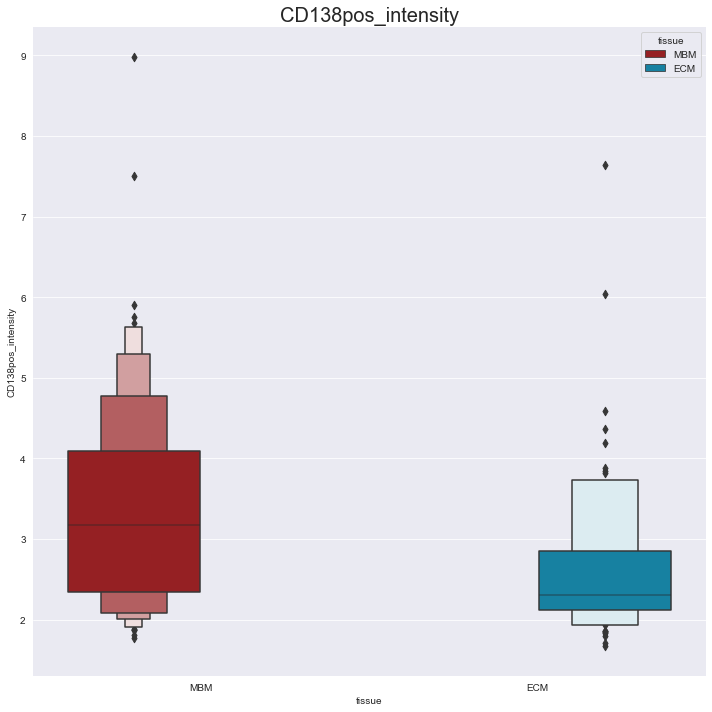

In [31]:
plot_distribution_boxen(metadata, "CD138pos_intensity", hue="tissue", palette=palette,
                        out=[abspath("./out/mets-boxen-CD138pos_mean_intensity_by_tissue.pdf"),
                             abspath("./out/mets-boxen-CD138pos_mean_intensity_by_tissue.png")])

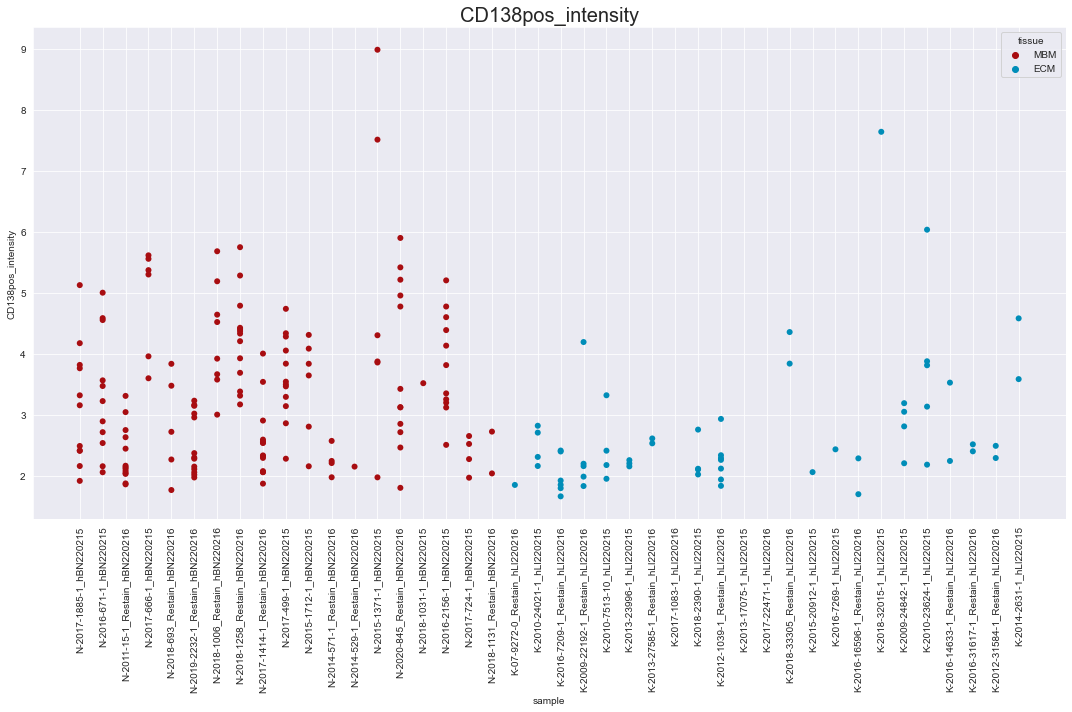

In [32]:
plot_sample_distributions(metadata, x="sample", marker="CD138pos_intensity", hue="tissue", palette=palette,
                          out=[abspath("./out/mets-scatter-CD138pos_mean_intensity_by_sample.pdf"),
                               abspath("./out/mets-scatter-CD138pos_mean_intensity_by_sample.png")])